# Evaluation Metrics for Classification

In this project we will evaluate the results we got in churn_prediction project.  
As you know we tested our model against validation data frame and got an accuracy of 80%.  
  
The question is how good 80% accuracy and what it really means in context of model quality. 
In this project, we will answer that questions and also show another methods of evaluation of binary classification models.

In [1]:
# let's do all the steps from the churn project
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:

df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(0)

df.columns = df.columns.str.lower().str.replace(' ', '_')

string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')


In [3]:

df.churn = (df.churn == 'yes').astype(int)
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=11)

y_train = df_train.churn.values
y_val = df_val.churn.values

del df_train['churn']
del df_val['churn']


In [4]:
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
               'phoneservice', 'multiplelines', 'internetservice',
               'onlinesecurity', 'onlinebackup', 'deviceprotection',
               'techsupport', 'streamingtv', 'streamingmovies',
               'contract', 'paperlessbilling', 'paymentmethod']
numerical = ['tenure', 'monthlycharges', 'totalcharges']
train_dict = df_train[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)


,dtype,<class 'numpy.float64'>
,separator,'='
,sparse,False
,sort,True


In [5]:
X_train = dv.transform(train_dict)
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)
LogisticRegression(random_state=1, solver='liblinear')
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict) 
y_pred = model.predict_proba(X_val)[:, 1]


In [6]:
small_subset = ['contract', 'tenure', 'totalcharges']
train_dict_small = df_train[small_subset].to_dict(orient='records')
dv_small = DictVectorizer(sparse=False)
dv_small.fit(train_dict_small)


,dtype,<class 'numpy.float64'>
,separator,'='
,sparse,False
,sort,True


In [7]:

X_small_train = dv_small.transform(train_dict_small)

model_small = LogisticRegression(solver='liblinear', random_state=1)
model_small.fit(X_small_train, y_train)
LogisticRegression(random_state=1, solver='liblinear')
val_dict_small = df_val[small_subset].to_dict(orient='records')
X_small_val = dv_small.transform(val_dict_small)

y_pred_small = model_small.predict_proba(X_small_val)[:, 1]

In [8]:
y_pred = model.predict_proba(X_val)[:, 1]
churn = y_pred >= 0.5
(churn == y_val).mean()

0.8016129032258065

## 1 - Classification Accuracy

Accuracy is the simplest method to evaulaute the classificator, by counting number of correctly predicted events and its share in total number of events.  
The first thing we need to figure out is why we chose **0.5** as the threshold
value. This was an arbitrary choice; however, in practice it is not difficult
to test other threshold values.

We can simply iterate over all possible thresholds and compute the accuracy
for each of them. Then we can choose the threshold that demonstrates the best
accuracy.


In [9]:
from sklearn.metrics import accuracy_score
thresholds = np.linspace(0, 1, 11)
for t in thresholds:
    churn = y_pred >= t
    acc = accuracy_score(y_val, churn)
    print('%0.2f %0.3f' % (t, acc))

0.00 0.261
0.10 0.595
0.20 0.690
0.30 0.755
0.40 0.782
0.50 0.802
0.60 0.790
0.70 0.774
0.80 0.742
0.90 0.739
1.00 0.739


As we can see the threshold value of 0.5 gives the best accuracy, as a rule 0.5 is the good threshold value in the beginning.  
However, we need to also check the other values to make sure that 0.5 is definitely the best value.

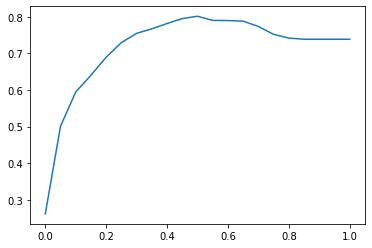

In [10]:
thresholds = np.linspace(0, 1, 21)
accuracies = []
for t in thresholds:
    acc = accuracy_score(y_val, y_pred >= t)
    accuracies.append(acc)
plt.plot(thresholds, accuracies)

Let's check how simpler model which used only three variables `contract`, `tenure` and `totalcharges`performs

In [11]:
val_dict_small = df_val[small_subset].to_dict(orient='records')
X_small_val = dv_small.transform(val_dict_small)
y_pred_small = model_small.predict_proba(X_small_val)[:, 1]


In [12]:
churn_small = y_pred_small >= 0.5
accuracy_score(y_val, churn_small)

0.7672043010752688

We see that accuracy of smaller model is 76% Thus accuracy of the bigger model is by 4% more accurate.

### 1.1 - Dummy Baseline

This metric seems good, but to determine whether **80%** is truly good, we need
to relate it to something — for example, to a simple baseline that is easy to
understand.

One such baseline can be a **dummy model** that always predicts the same value.

In our example, the dataset is not balanced, and we do not have many churned
customers. Therefore, a dummy model can always predict the majority class —
**“no churn.”** In other words, this model will always output **False**,
regardless of the features.

This is not a very useful model, but it can be used as a baseline and compared
with other models.

Let us create this baseline prediction:


In [13]:
size_val = len(y_val)
baseline = np.repeat(False, size_val)

In [14]:
accuracy_score(baseline, y_val)

0.7387096774193549

The output is almost 74% which means accuracy of dummy baseline model is 74%.  
As we can see the smaller model is only 2% more accurate and the bigger model is just 6%.

Churn prediction is a difficult task, and this may indeed be a significant
improvement. However, this is not at all obvious if we rely only on the
accuracy metric.

According to accuracy alone, our model is only slightly better than the dummy
model, which treats all customers as reliable and does not attempt to retain
any of them.

Therefore, we need additional metrics — other ways of measuring the quality of
our model. These metrics are based on the **confusion matrix**, a concept that
we will discuss in the next section.


### 1.2 - Confusion Matrix

Although accuracy is easy to understand, it is not always the best metric.
In fact, sometimes it can even be misleading.

We have already seen how this happens: the accuracy of our model is **80%**, and
although this value seems good, it is only **6%** better than the accuracy of
the dummy model, which always produces the same prediction — **“no churn.”**

This situation usually arises when we have a **class imbalance**
(more instances of one class than of the other). We know that this definitely
applies to our task: **74%** of customers did not churn, and only **26%** did.

Such cases require a different way of measuring the quality of our models.
There are several options for this, and most of them are based on the
**confusion matrix** — a table that compactly represents all possible outcomes
of our model’s predictions.


- **True Negative (TN):** we predict **False** (“no churn”), and the actual label
  is also **False** (“no churn”).

- **True Positive (TP):** we predict **True** (“churn”), and the actual label
  is also **True** (“churn”).

- **False Negative (FN):** we predict **False** (“no churn”), but in reality
  it is **True** (the customer has churned).

- **False Positive (FP):** we predict **True** (“churn”), but in reality
  it is **False** (the customer stayed with us).


In [15]:
t = 0.5
predict_churn = (y_pred >= t) 
predict_no_churn = (y_pred < t)

In [16]:
t = 0.5
predict_churn = (y_pred >= t)
predict_no_churn = (y_pred < t)
actual_churn = (y_val == 1)
actual_no_churn = (y_val == 0)

In [17]:
true_positive = (predict_churn & actual_churn).sum()
false_positive = (predict_churn & actual_no_churn).sum()

false_negative = (predict_no_churn & actual_churn).sum()
true_negative = (predict_no_churn & actual_no_churn).sum()


In [18]:
confusion_table = np.array( 
 [[true_negative, false_positive], 
 [false_negative, true_positive]])
confusion_table

array([[1202,  172],
       [ 197,  289]])

In [19]:
confusion_table / confusion_table.sum()


array([[0.64623656, 0.09247312],
       [0.10591398, 0.15537634]])

The model makes many mistakes of false_positive and false_negative 9% and 11% respectively

The values from the confusion matrix form the basis for many other evaluation
metrics. For example, we can compute **accuracy** by taking all correct
predictions (**TN** and **TP**) and dividing this number by the total number of
observations across all four cells of the table:  
$$
\text{accuracy} = \frac{TN + TP}{TN + TP + FN + FP}
$$


In [20]:
churn = y_pred >= 0.5
accuracy_score(y_val, churn)

0.8016129032258065

### 1.3 -  Precision and Recall

Let us start with **precision**.  
This metric tells us how many of the positive predictions were correct.  
It is the proportion of correctly predicted positive examples.

In our case, this is the number of customers who actually churned (**TP**)
compared to the number of customers that were predicted to churn
according to our model, that is (**TP + FP**).

$$
P = \frac{TP}{TP + FP}
$$


In [21]:
precision = true_positive/(true_positive + false_positive)
print(f"Precision: {round(precision,3)*100}%")

Precision: 62.7%


**Recall** is the proportion of correctly classified positive examples
among all positive examples.

In our case, to compute recall, we first select all customers who actually
churned and then check how many of them were correctly identified by the model.

The formula for recall is:

$$
R = \frac{TP}{TP + FN}
$$


In [22]:
recall = true_positive/(true_positive+false_negative)
print(f"Recall: {round(recall,3)*100}%")

Recall: 59.5%


Model recall is the proportion of correctly predicted churned customers (**TP**)
among all customers who actually churned (**TP + FN**).


- **Precision** — the percentage of correct predictions (**TP**) among customers
  predicted as **“churn”** (**TP + FP**).

- **Recall** — the percentage of correct **“churn”** predictions (**TP**) among
  all customers who actually churned (**TP + FN**).


Both precision and recall refer to correct predictions (TP), but they use different denominators.

- For **precision**, the denominator is the number of customers predicted as churn.

- For **recall**, the denominator is the number of customers who actually churned.

**Precision** helps us understand how many people received a promotional message
by mistake. The higher the precision, the fewer false positives we have.

A precision of **62%** means that **62%** of the contacted customers were indeed
planning to churn (our true positive results), while the remaining **38%** were
not (false positive results).

**Recall** helps us understand how many churned customers we failed to detect.
The better the recall, the fewer false negatives we have.

A recall of **59%** means that we reach only **59%** of all users who plan to
leave (true positive results) and fail to detect the remaining **41%**
(false negative results).

Obviously, in both cases we do not really care about the number of
**true negative** results: even if we correctly identify that people are not
leaving, we do not plan to take any action in response.


### 1.4 -  ROC curve and AUC score

The metrics we have considered so far work only with **binary predictions** —
when the output contains only **True** and **False** values. However, there are
ways to evaluate a model’s performance across **all possible threshold values**.
**ROC curves** are one such method.

ROC stands for **Receiver Operating Characteristic**, and this metric was
originally developed to evaluate the reliability of radar systems during
World War II. It was used to assess how well a detector could distinguish
between two signals: whether an aircraft was detected or not.

Today, ROC serves a similar purpose: it shows how well a model can separate
two classes — the positive and the negative ones. In our case, these are
the **“churn”** and **“no churn”** classes.

To build ROC curves, we need two metrics:
**TPR** (true positive rate) and **FPR** (false positive rate).


The ROC curve is based on two quantities, **FPR** and **TPR**:

- **False Positive Rate (FPR)** — the proportion of false positive results
  among all negative cases.

- **True Positive Rate (TPR)** — the proportion of true positive results
  among all positive examples.

As with precision and recall, these values are based on the **confusion matrix**.
We can compute them using the following formulas:

$$
\text{FPR} = \frac{FP}{FP + TN}
$$

$$
\text{TPR} = \frac{TP}{TP + FN}
$$


In [23]:
false_positive_rate = false_positive/(false_positive + true_negative)
false_positive_rate

0.12518195050946143

**FPR** is the proportion of users for whom we predicted churn among all users
who did **not** actually churn.

A small FPR value indicates that the model performs well — it produces few
false positives. The **smaller** the metric the better it is.


In [24]:
true_positive_rate = true_positive/(true_positive + false_negative)
true_positive_rate

0.5946502057613169

**TPR** is the proportion of users for whom we predicted churn among all users
who actually terminated their contract.

Note that **TPR** is the same as **recall**, so the higher the TPR, the better.


In order to use FPR and TPR In ROC, we need to use many different threshold values.  
  
Instead of evaluating the model at a single specific threshold, we can do this
for an entire range of thresholds — just as we did earlier in this project for
accuracy.

To do this, we first iterate over different threshold values and compute the
values of the confusion matrix for each of them.


In [25]:
scores = []
thresholds = np.linspace(0, 1, 101)
for t in thresholds:
    tp = ((y_pred >= t) & (y_val == 1)).sum()
    fp = ((y_pred >= t) & (y_val == 0)).sum()
    fn = ((y_pred < t) & (y_val == 1)).sum()
    tn = ((y_pred < t) & (y_val == 0)).sum()
    scores.append((t, tp, fp, fn, tn))

In [26]:
df_scores = pd.DataFrame(scores)
df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

In [27]:
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,486,1374,0,0
10,0.1,458,726,28,648
20,0.2,421,512,65,862
30,0.3,380,350,106,1024
40,0.4,337,257,149,1117
50,0.5,289,172,197,1202
60,0.6,200,105,286,1269
70,0.7,99,34,387,1340
80,0.8,7,1,479,1373
90,0.9,0,0,486,1374


In [29]:
# Now we can calculate TPR and FPR 
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn) 
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

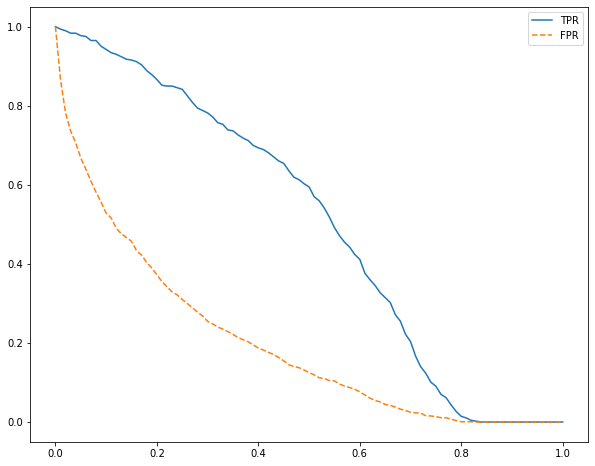

In [35]:
plt.figure(figsize=(10,8))
plt.plot(df_scores.threshold, df_scores.tpr, label='TPR') 
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR',linestyle='--') 
plt.legend()

Both **TPR** and **FPR** start at **100%** — at a threshold of **0.0** we predict
**“churn”** for everyone.

As the threshold increases, both metrics decrease, but at different rates.
Ideally, **FPR** should decrease very quickly. A small FPR indicates that the
model makes very few mistakes when predicting negative examples
(false positive results).

On the other hand, **TPR** should decrease slowly, ideally remaining close to
**100%** the entire time. This would mean that the model is good at predicting
true positive results.

To better understand the **TPR** and **FPR** metrics, let us compare them with
two baseline models: a **random** model and an **ideal** model.  
Let us start with the random one.


#### 1.4.1 - Random Baseline Model

In [36]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [37]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []
    thresholds = np.linspace(0, 1, 101)
    for t in thresholds:
        tp = ((y_pred >= t) & (y_val == 1)).sum()
        fp = ((y_pred >= t) & (y_val == 0)).sum()
        fn = ((y_pred < t) & (y_val == 1)).sum()
        tn = ((y_pred < t) & (y_val == 0)).sum()
        scores.append((t, tp, fp, fn, tn))
    df_scores = pd.DataFrame(scores)
    df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    return df_scores

In [39]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,486,1374,0,0,1.000000,1.000000
10,0.1,440,1236,46,138,0.905350,0.899563
20,0.2,392,1101,94,273,0.806584,0.801310
30,0.3,339,972,147,402,0.697531,0.707424
40,0.4,288,849,198,525,0.592593,0.617904
50,0.5,239,723,247,651,0.491770,0.526201
60,0.6,193,579,293,795,0.397119,0.421397
70,0.7,152,422,334,952,0.312757,0.307132
80,0.8,98,302,388,1072,0.201646,0.219796
90,0.9,57,147,429,1227,0.117284,0.106987


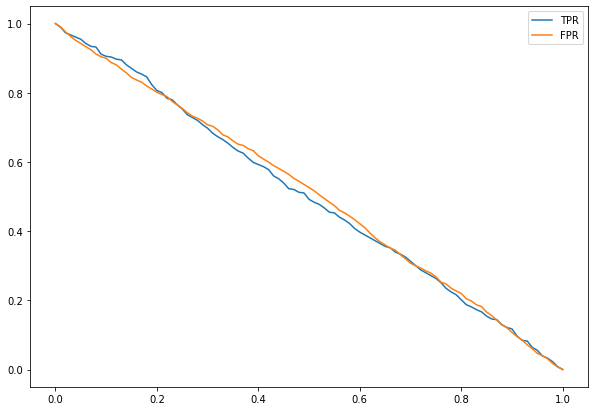

In [41]:
plt.figure(figsize=(10,7))
plt.plot(df_rand.threshold, df_rand.tpr, label='TPR') 
plt.plot(df_rand.threshold, df_rand.fpr, label='FPR') 
plt.legend()

Why at threshold 0.0 both TPR and FPR are 100%

⚠️ This is a very common confusion point, so let’s be precise.

Threshold = 0.0

Every probability is ≥ 0.0

So the model predicts “churn” for everyone

What happens?

All actual churners are predicted as churn
→ TPR = 100%

All non-churners are also predicted as churn
→ FPR = 100%

✔️ This is why both are 100% at threshold 0.0  

Lowering the threshold increases both TPR and FPR; raising the threshold decreases both.

#### 1.4.2 - The Ideal Model

An ideal model always makes correct decisions.  
Let us take this one step further and consider an **ideal ranking model**.

This model produces scores in such a way that customers with **“churn”**
always receive higher scores than customers with **“no churn.”**
In other words, the predicted probability for all churned customers
must be higher than the predicted probability for customers who did not churn.


In [42]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_pred_ideal = np.linspace(0, 1, num_neg + num_pos)

In [43]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_pred_ideal)

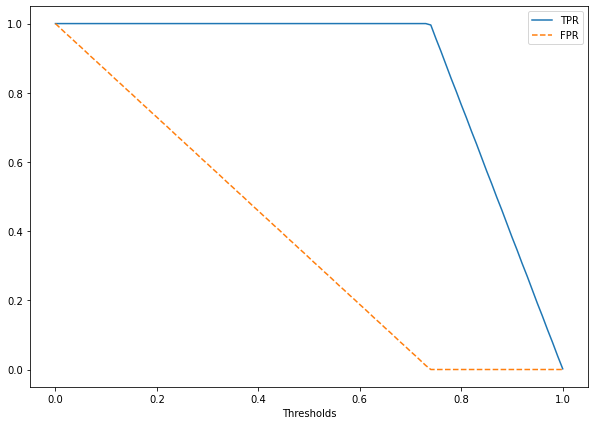

In [46]:
plt.figure(figsize=(10,7))
plt.plot(df_ideal.threshold, df_ideal.tpr, label='TPR') 
plt.plot(df_ideal.threshold, df_ideal.fpr, label='FPR',linestyle='--') 
plt.xlabel("Thresholds")
plt.legend()

- For threshold values **below 0.74**, we always correctly classify all customers
  with **“churn”**; this is why **TPR** remains at **100%**.  
  On the other hand, we incorrectly classify some customers with **“no churn”**
  as **“churn”** — these are our **false positive** results.  
  As we increase the threshold, fewer and fewer **“no churn”** customers are
  classified as **“churn,”** so **FPR** decreases.  
  At a threshold of **0.6**, we incorrectly predict **“churn”** for **258**
  customers who actually did not churn.

- A threshold value of **0.74** represents the **ideal situation**: all customers
  with **“churn”** are classified as **“churn,”** and all customers with
  **“no churn”** are classified as **“no churn.”**  
  That is why **TPR = 100%** and **FPR = 0%**.

- In the range from **0.74 to 1.0**, we always correctly classify all customers
  with **“no churn,”** so **FPR** remains at **0%**.  
  However, as the threshold increases, we start misclassifying more and more
  customers with **“churn”** as **“no churn,”** so **TPR** decreases.  
  At a threshold of **0.8**, **114 out of 446** churned customers are incorrectly
  classified as **“no churn.”** Only **372** predictions are correct, so
  **TPR** equals **76%**.


#### 1.4.3 - ROC Curve

To create an ROC curve, instead of plotting **FPR** and **TPR** against different
threshold values, we plot them **against each other**. For comparison, we also
add the **ideal** and **random** models to the graph.

As a result, we obtain the **ROC curve**. When plotting it, we can see
that the ROC curve of a **random classifier** is practically a straight line
starting in the lower-left corner and going upward to the right.

In contrast, for an **ideal model**, the curve first goes straight up until it
reaches **100% TPR**, and then moves to the right until it reaches **100% FPR**.


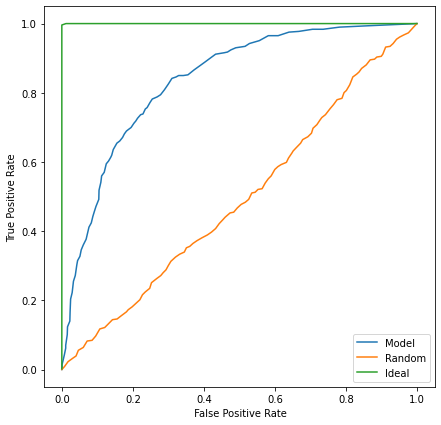

In [49]:
plt.figure(figsize=(7, 7))
plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot(df_rand.fpr, df_rand.tpr, label='Random')
plt.plot(df_ideal.fpr, df_ideal.tpr, label='Ideal')
plt.xlabel(" False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

Our models should always lie somewhere between these two curves. Logically, a
model should be as close as possible to the **ideal curve** and as far as
possible from the **random** one.

The ROC curve of a random model serves as a good visual **baseline**. When we
add it to the plot, it helps us understand how far our model is from this
baseline. That is why it is recommended to always include this diagonal line
in the graph.


[]

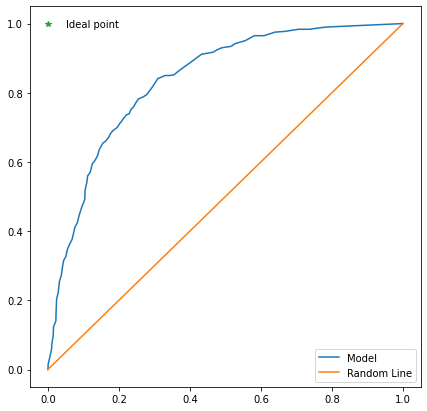

In [57]:
plt.figure(figsize=(7, 7)) 
plt.plot(df_scores.fpr, df_scores.tpr,label='Model') 
plt.plot([0, 1], [0, 1], label='Random Line')
plt.plot(0, 1, marker='*')
plt.annotate('Ideal point', xy=(0.05, 0.99))
plt.legend()
plt.plot()

We want our model curve to be as close as possible to that "Ideal Point". Even though, calculating FPR and TPR for multiple threshold values is good exercise.  
We don't have to do it manually we can use Scikit-learn Library

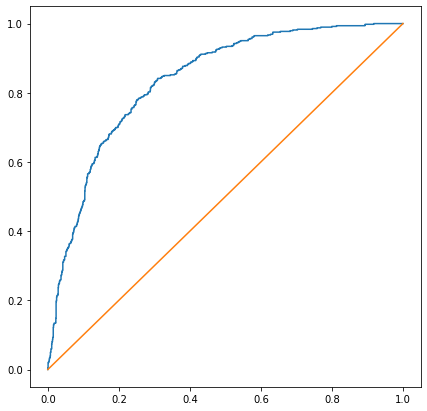

In [59]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred) 
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr) 
plt.plot([0, 1], [0, 1])

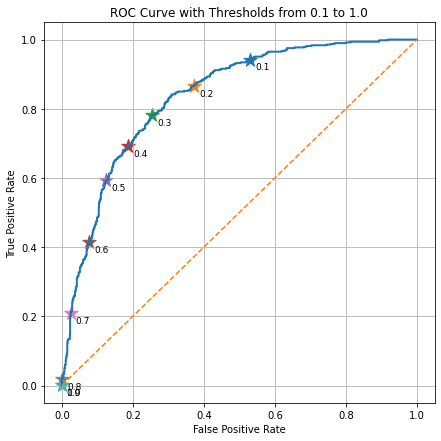

In [70]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, linewidth=2)

plt.plot([0, 1], [0, 1], linestyle='--')

desired_thresholds = np.arange(0.1, 1.01, 0.1)

for thr in desired_thresholds:
    idx = np.argmin(np.abs(thresholds - thr))
    
    plt.scatter(fpr[idx], tpr[idx], marker='*', s=200)
    plt.annotate(
        f"{thr:.1f}",
        (fpr[idx], tpr[idx]),
        textcoords="offset points",
        xytext=(5, -10),
        fontsize=9
    )

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with Thresholds from 0.1 to 1.0")
plt.grid(True)
plt.show()


On the ROC plot, we start at the point **(0, 0)** — the point in the lower-left
corner. This corresponds to **0% FPR** and **0% TPR**, which occurs at high
threshold values, such as **1.0**, when no customer exceeds this threshold.

In these cases, we ultimately predict **“no churn”** for everyone. This is why
**TPR = 0%**: we never correctly predict churn for any customers. On the other
hand, **FPR = 0%**, because this dummy model correctly predicts **“no churn”**
for all customers who did not churn, so there are no false positives.

As we move upward along the curve, we consider **FPR** and **TPR** values
evaluated at lower threshold values. At a threshold of **0.7**, **FPR** changes
only slightly, from **0% to 2%**, while **TPR** increases from **0% to 20%**.

Following this line, we continue lowering the threshold and evaluating the model
at smaller values, predicting **“churn”** for an increasing number of
customers. At some point, we cover most of the positive cases (customers who
churned). For example, at a threshold of **0.2**, we predict **“churn”** for the
majority of users; that is, many of these predictions turn out to be false
positives. Then **FPR** begins to grow faster than **TPR**; at a threshold of
**0.2**, it already reaches almost **40%**.

Eventually, we reach a threshold of **0.0** and predict **“churn”** for everyone,
thus reaching the upper-right corner of the ROC plot.

When we start with high threshold values, all models are equivalent: any model
with high thresholds degenerates into a constant “model” that always predicts
**False**. As we lower the threshold, we begin to predict **“churn”** for some
customers. The better the model, the more customers it correctly predicts as
**“churn,”** which leads to a higher **TPR**. Similarly, good models have a
lower **FPR**, because they produce fewer false positive results.

Thus, the ROC curve of a good model rises as steeply as possible at first and
only then starts to bend to the right. Poor models, on the other hand, have
higher **FPR** and lower **TPR** from the very beginning, so their curves tend
to bend to the right earlier.


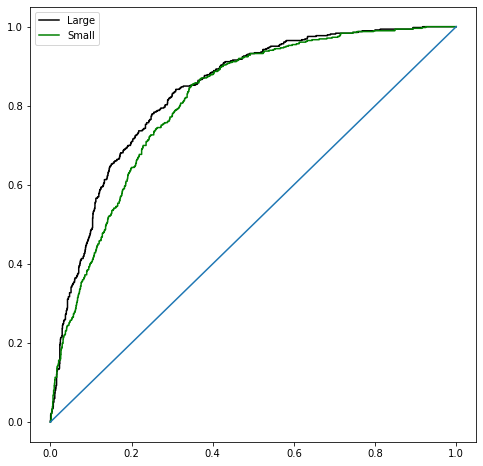

In [73]:
fpr_large, tpr_large, _ = roc_curve(y_val, y_pred) 
fpr_small, tpr_small, _ = roc_curve(y_val, y_pred_small)
plt.figure(figsize=(8, 8))
plt.plot(fpr_large, tpr_large, color='black', label='Large') 
plt.plot(fpr_small, tpr_small, color='green', label='Small') 
plt.plot([0, 1], [0, 1])
plt.legend()



We can see that bigger model is closer to the ideal point for multiple threshold values.  
ROC curves are quite useful on their own, but we also have another metric based on them: the area under the ROC curve (AUC)

#### 1.4.4 Area under the ROC curve (AUC)

When evaluating our models using the ROC curve, we want them to be as close as
possible to the **ideal point** and as far as possible from the **random
baseline**.

We can quantify this “closeness” by measuring the **area under the ROC curve**.
This metric — abbreviated as **AU ROC**, or more commonly simply **AUC** — can be
used as a performance measure for **binary classification** models.

An ideal model forms a **1 × 1 square**, so the area under its ROC curve equals
**1**, or **100%**. A random model occupies only half of this area, so its **AUC**
is **0.5**, or **50%**.

The AUC values of our two models — the large and the small one — will lie
somewhere between the random baseline at **50%** and the ideal curve at
**100%**.


> **IMPORTANT**  
- **AUC of 0.9** indicates **very good** model performance.  
- **0.8** indicates **acceptable** performance.
- **0.7** indicates **not very effective** performance.
-  **0.6** indicates **rather poor** performance.


In [74]:
from sklearn.metrics import auc 
auc(df_scores.fpr, df_scores.tpr)

0.8359001084215382

In [75]:
df_scores_small = tpr_fpr_dataframe(y_val, y_pred_small)

In [77]:
auc(df_scores_small.fpr,df_scores_small.tpr)

0.8108718050089552

AUC for a bigger model is 84% and 81% for small model.

In [78]:
from sklearn.metrics import roc_auc_score 
roc_auc_score(y_val, y_pred)

0.8363396349608545

If all we need is **AUC**, we do not have to compute the ROC curve beforehand.
We can take the shortest path and use the `roc_auc_score` function from
Scikit-learn, which does everything for us and simply returns the **AUC**
of our model:


In [79]:
from sklearn.metrics import roc_auc_score 
roc_auc_score(y_val, y_pred)

0.8363396349608545

Suppose we randomly select one customer who we know churned and one customer
who did not, and then apply the model to both and evaluate the result for each.
We want the model to assign a higher score to the customer with **“churn”**
than to the one with **“no churn.”**

**AUC** answers the question:
“If I randomly choose one churner and one non-churner, how likely is my model to rank them correctly?”


### **EXAMPLE**
### Customers who churned (positive class)

| Customer | True label | Model score |
|---------|------------|-------------|
| A       | churn      | 0.90        |
| B       | churn      | 0.70        |
| C       | churn      | 0.60        |


### Customers who did NOT churn (negative class)

| Customer | True label | Model score |
|---------|------------|-------------|
| D       | no churn   | 0.65        |
| E       | no churn   | 0.40        |
| F       | no churn   | 0.20        |


### Pairwise comparisons

| Churned score | No-churn score | Correct ranking |
|--------------|----------------|-----------------|
| 0.90         | 0.65           | ✅ Yes          |
| 0.90         | 0.40           | ✅ Yes          |
| 0.90         | 0.20           | ✅ Yes          |
| 0.70         | 0.65           | ✅ Yes          |
| 0.70         | 0.40           | ✅ Yes          |
| 0.70         | 0.20           | ✅ Yes          |
| 0.60         | 0.65           | ❌ No           |
| 0.60         | 0.40           | ✅ Yes          |
| 0.60         | 0.20           | ✅ Yes          |


We can prove it, if we run an experiment 10,000 times and then count how many times model assigned higher score to **churn** client in comparison to score that was assigned to **non-churned** client.

In [84]:
neg = y_pred[y_val==0]
pos = y_pred[y_val==1]
np.random.seed(1)
neg_choice = np.random.randint(low=0, high=len(neg), size=10000)
pos_choice = np.random.randint(low=0, high=len(pos), size=10000)
(pos[pos_choice] > neg[neg_choice]).mean()


0.8356

It is quite close to **AUC** score. This interpretation of **AUC** gives us additional representation of quality of our models.

An ideal model orders all customers in such a way that customers with
**“no churn”** come first, followed by customers with **“churn.”**
With such an ordering, the **AUC** is always equal to **1.0**: the score of a
randomly chosen churned customer is always higher than the score of a
non-churned customer.

On the other hand, a random model simply shuffles customers, so the score of a
churned customer has only a **50%** probability of being higher than the score
of a non-churned customer.

Thus, **AUC** not only provides a way to evaluate models across all possible
threshold values, but also describes how well the model separates the two
classes — in our case, **“churn”** and **“no churn.”**


This makes **AUC** the default classification metric in most situations, and it
is often the one we use when searching for the best set of parameters for our
models.

The process of searching for the best parameters is called
**parameter tuning**.


## 2- Parameter Tuning (K-fold cross-validation)

We tested our models using a simple **holdout
validation** scheme. In this approach, we take a portion of the data and keep
it exclusively for validation purposes.

This is a good practice, but it does not always provide the full picture. It
tells us how well the model performs on these specific data points. However,
this does not necessarily mean that the model will perform equally well on
other data points.
